# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [61]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/nilsw/Lab1ID2223
HopsworksSettings initialized!


In [62]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [63]:
#today = datetime.datetime.now() - datetime.timedelta(0)
#tomorrow = today + datetime.timedelta(days = 1)
#today

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [64]:
def get_env(street,city):
    project = hopsworks.login()
    fs = project.get_feature_store() 
    
    secrets = hopsworks.get_secrets_api()
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{city.lower()}_{street.lower()}").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']

    return project, fs, country, city, street

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [65]:
def get_model(project,street,city):
    mr = project.get_model_registry()
    
    retrieved_model = mr.get_model(
        name=f"air_quality_xgboost_model_v_agrade_{city.lower()}_{street.lower()}",
        version=1,
    )
    print(retrieved_model)
    
    fv = retrieved_model.get_feature_view()
    print(fv)
    
    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{city.lower()}_{street.lower()}.json")
    
    # Displaying the retrieved XGBoost regressor model
    retrieved_xgboost_model

    return retrieved_xgboost_model, fv

In [66]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
#retrieved_xgboost_model = XGBRegressor()

#retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
#retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [67]:
def get_forecast_stuff(fs,street,today,city):
    weather_fg = fs.get_feature_group(
        name=f"weather_v_agrade_{city.lower()}_{street.lower()}",
        version=1,
    )
    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    batch_data

    return batch_data, weather_fg

In [68]:
# NEW. ADDS ROLLING MEAN FOR FIRST DAY AND 0 VALUE IN ALL COLUMN FOR ROLL
"""import pytz

adj_tomorrow = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)

air_quality_group = fs.get_feature_group(name='air_quality', version=1)
first_init_roll = air_quality_group.filter(air_quality_group.date >= adj_tomorrow -  datetime.timedelta(4)).read()
print(first_init_roll)
batch_data["roll"] = pd.Series(0, index=batch_data.index).astype("float64")
batch_data.loc[batch_data["date"] == adj_tomorrow, "roll"] = first_init_roll["pm25"].mean()
#batch_data"""
def add_rolling(fs,street,batch_data,city):
    import pytz
    
    adj_tomorrow = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    adj_2day = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=2)).replace(hour=0, minute=0, second=0, microsecond=0)
    adj_3day = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=3)).replace(hour=0, minute=0, second=0, microsecond=0)
    
    air_quality_group = fs.get_feature_group(name=f"air_quality_v_agrade_{city.lower()}_{street.lower()}", version=1)
    first_init_roll = air_quality_group.filter(air_quality_group.date >= adj_tomorrow -  datetime.timedelta(4)).read()
    #print(first_init_roll)
    pm_series = first_init_roll.sort_values('date')['pm25'].tail(3)
    
    rolling3 = pm_series.mean()
    lag1 = pm_series.iloc[-1]
    lag2 = pm_series.iloc[-2]
    lag3 = pm_series.iloc[-3]
    
    m1 = batch_data['date'] == adj_tomorrow
    m2 = batch_data['date'] == adj_2day
    m3 = batch_data['date'] == adj_3day
    
    batch_data.loc[m1, 'rolling3'] = rolling3
    batch_data.loc[m1, ['lag1d', 'lag2d', 'lag3d']] = [lag1, lag2, lag3]
    
    batch_data.loc[m2, ['lag2d', 'lag3d']] = [lag1, lag2]
    
    batch_data.loc[m3, ['lag3d']] = lag1
    
    batch_data

    return batch_data, adj_tomorrow, first_init_roll

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [69]:
# OLD SOLUTION IGNORING ROLLING MEAN
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

###########################
"""
old loop logic
predicted_pm = retrieved_xgboost_model.predict(
        batch_data.loc[batch_data["date"] == time_obj,
    ["roll", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]])
    batch_data.loc[batch_data["date"] == time_obj, "predicted_pm25"] = predicted_pm
    
    first_init_roll.loc[len(first_init_roll)] = {"date":time_obj, "pm25":predicted_pm[0], "roll":0.0, "country":"Japan", "city":"saitama-ken", "street":"gakuendai", "url":"https://api.waqi.info/feed/@9937"}
    time_obj += datetime.timedelta(days=1)
    batch_data.loc[batch_data["date"] == time_obj, "roll"] = first_init_roll["pm25"].tail(3).mean()

"""
# NEW SOLUTION WITH ROLLING MEAN
def predictions(adj_tomorrow,batch_data,retrieved_xgboost_model,country,city,street,url,first_init_roll):
    time_obj = adj_tomorrow
    
    for _ in range(len(batch_data)):
    
        mask = batch_data["date"] == time_obj
        
        X = batch_data.loc[mask,["rolling3", "lag1d", "lag2d", "lag3d", 
                                 "temperature_2m_mean", "precipitation_sum", 
                                 "wind_speed_10m_max", "wind_direction_10m_dominant"]]
    
        y_pred = retrieved_xgboost_model.predict(X)[0]
        batch_data.loc[mask, "predicted_pm25"] = y_pred
    
        new_data = {
            "date": time_obj,
            "pm25": y_pred,
            "country": country,
            "city": city,
            "street": street,
            "url": url,
        }
    
        first_init_roll = pd.concat([first_init_roll, pd.DataFrame([new_data])], ignore_index=True)
    
        time_next = time_obj + datetime.timedelta(days=1)
    
        if(batch_data["date"]== time_next).any():
            recent = first_init_roll.sort_values("date")["pm25"].tail(3)
    
            rolling3 = recent.mean()
            lag1 = recent.iloc[-1]
            lag2 = recent.iloc[-2]
            lag3 = recent.iloc[-3]
    
            mask_next = batch_data["date"] == time_next
            batch_data.loc[mask_next, ["rolling3", "lag1d", "lag2d", "lag3d"]] = [rolling3,lag1,lag2,lag3]
    
        time_obj = time_next
        
            
    
    
    
    batch_data

    return batch_data

In [70]:
#batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [71]:
def add_info_data(batch_data,street,city,country):
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data = batch_data.sort_values(by=['date'])
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data

    return batch_data

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [72]:
#batch_data.info()

In [73]:
def create_forecast(street,city,batch_data):
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{city.lower()}_{street.lower()}.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    
    plt.show()
    return pred_file_path

In [74]:
def create_monitor_fg(street,batch_data,fs,city):
    # Get or create feature group
    monitor_fg = fs.get_or_create_feature_group(
        name=f"aq_predictions_v_agrade_{city.lower()}_{street.lower()}",
        description='Air Quality prediction monitoring',
        version=1,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )
    monitor_fg.insert(batch_data, wait=True)

    return monitor_fg

In [75]:
#monitor_fg.insert(batch_data, wait=True)

In [76]:
def create_monitor_df(monitor_fg):
    # We will create a hindcast chart for  only the forecasts made 1 day beforehand
    monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    monitoring_df

    return monitoring_df

In [77]:
def create_aq_df(fs,street,city):
    air_quality_fg = fs.get_feature_group(name=f"air_quality_v_agrade_{city.lower()}_{street.lower()}", version=1)
    air_quality_df = air_quality_fg.read()
    air_quality_df

    return air_quality_fg, air_quality_df

In [78]:
def hindcast(air_quality_df, monitoring_df):
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]
    
    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        pass
        #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
        # we need to predict with our model since its C version
        
        """features_df = weather_fg.read()
        features_df = features_df.sort_values(by=['date'], ascending=True)
        features_df = features_df.tail(10)
    
        X = pd.concat([
        batch_data.sort_values(by=['date'], ascending=True)[["date","roll"]].reset_index(drop=True),
        features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].reset_index(drop=True)
        ], axis=1)
        
        X['predicted_pm25'] = retrieved_xgboost_model.predict(X[["roll","temperature_2m_mean","precipitation_sum","wind_speed_10m_max","wind_direction_10m_dominant"]])
        df = pd.merge(X, air_quality_df[['date','pm25','street','country',"city"]], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
        monitor_fg.insert(df, write_options={"wait_for_job": True})"""
        
    hindcast_df

    return hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [79]:
def plot_hindcast(street,city,hindcast_df):
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{city.lower()}_{street.lower()}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()
    return hindcast_file_path

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [80]:
def upload_hops(project, today, city, street,pred_file_path,hindcast_file_path):
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality_v_agrade") == False:
        dataset_api.mkdir("Resources/airquality_v_agrade")
    dataset_api.upload(pred_file_path, f"Resources/airquality_v_agrade/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality_v_agrade/{city}_{street}_{str_today}", overwrite=True)
    
    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_v_agrade")

2025-11-16 15:19:45,360 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:19:45,446 INFO: Initializing external client
2025-11-16 15:19:45,448 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:19:46,271 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:19:47,118 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_miyoshi_ikedacho_machi', version: 1)
2025-11-16 15:19:52,158 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/539806 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/101317 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27597 elapsed<00:00 remaining<?

XGBRegressor(base_score='4.4936035E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 
Finished: Reading data from Hopsworks, using 

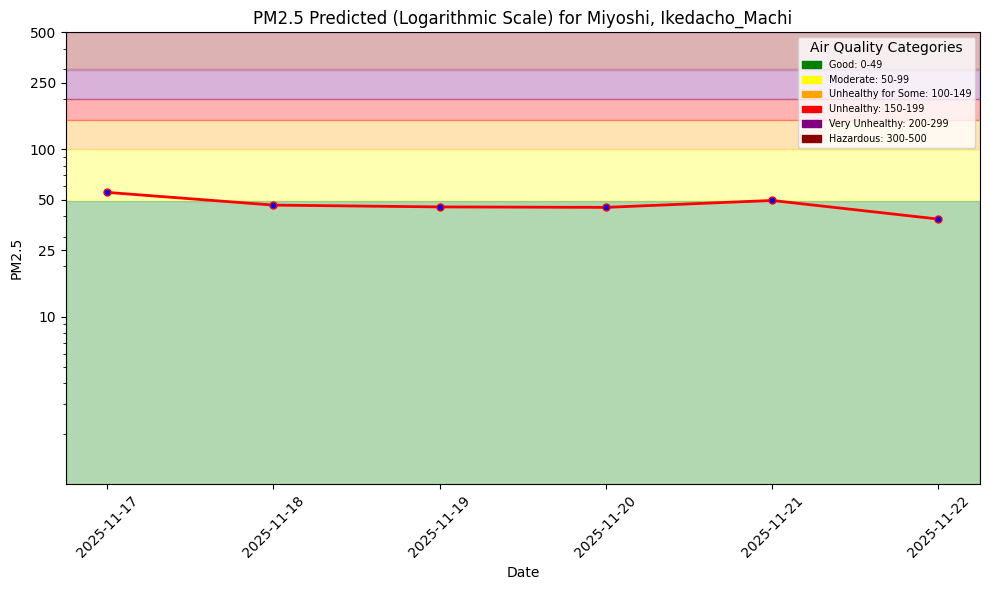

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1724768


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_miyoshi_ikedacho_machi_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_miyoshi_ikedacho_machi_1_offline_fg_materialization/executions
2025-11-16 15:20:22,558 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 15:20:25,739 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:20:28,909 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:22:19,999 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:22:20,165 INFO: Waiting for log aggregation to finish.
2025-11-16 15:22:28,808 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
Finished: Reading data from Hopswo

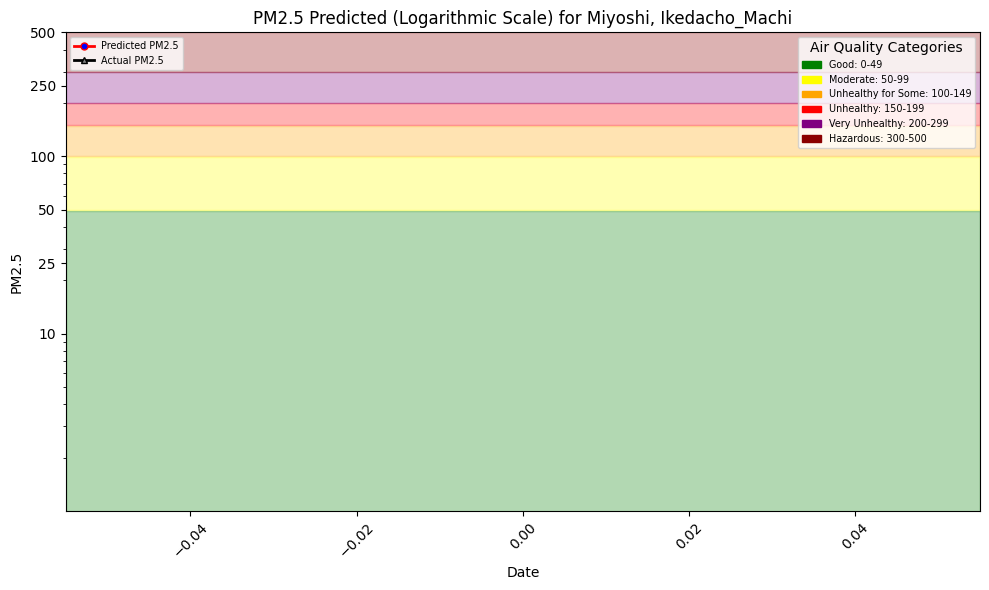

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_miyoshi_ikedacho_machi.png: 0.000%|…

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_miyoshi_ikedacho_machi.png: 0.…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:22:38,666 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:22:38,675 INFO: Initializing external client
2025-11-16 15:22:38,676 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:22:39,303 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:22:40,334 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_mima_wakimachi_oaza_inoshiri', version: 1)
2025-11-16 15:22:45,716 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/543054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/103985 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27012 elapsed<00:00 remaining<?

XGBRegressor(base_score='4.341717E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 
Finished: Reading data from Hopsworks, using H

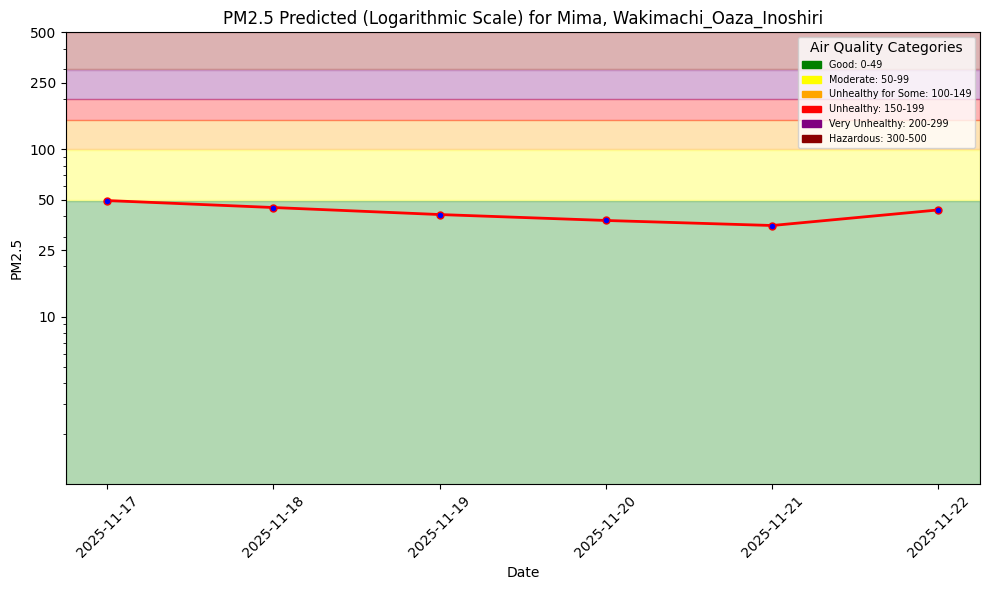

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1721731


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_mima_wakimachi_oaza_inoshiri_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_mima_wakimachi_oaza_inoshiri_1_offline_fg_materialization/executions
2025-11-16 15:23:14,839 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:23:18,002 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:25:02,864 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:25:03,021 INFO: Waiting for log aggregation to finish.
2025-11-16 15:25:11,672 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.25s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


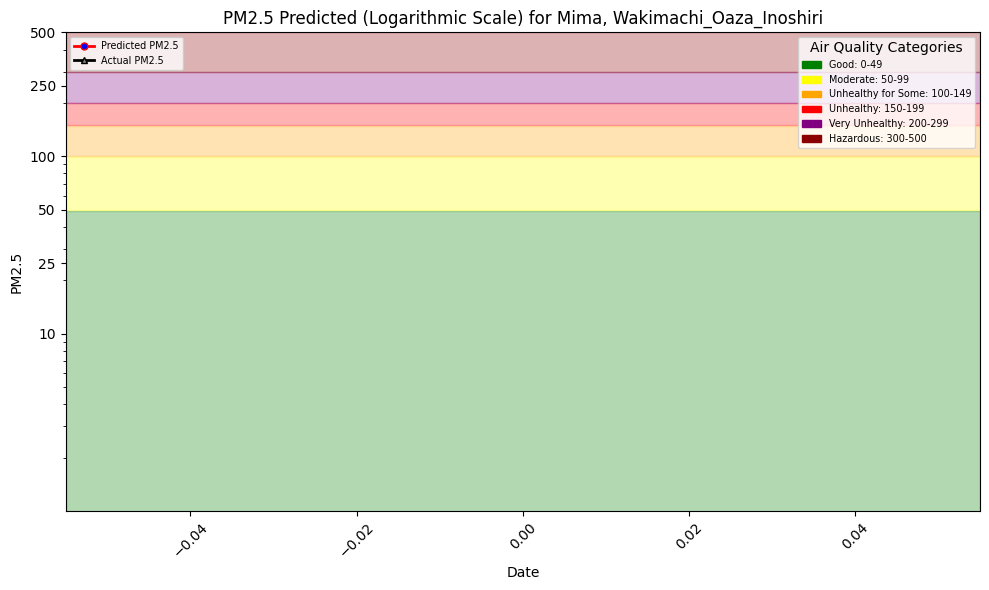

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_mima_wakimachi_oaza_inoshiri.png: 0…

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_mima_wakimachi_oaza_inoshiri.p…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:25:21,920 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:25:21,933 INFO: Initializing external client
2025-11-16 15:25:21,934 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:25:22,640 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:25:23,535 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_naruto_muyacho_tateiwa', version: 1)
2025-11-16 15:25:28,338 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/537065 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108291 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26512 elapsed<00:00 remaining<?

XGBRegressor(base_score='4.2909935E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 
Finished: Reading data from Hopsworks, using 

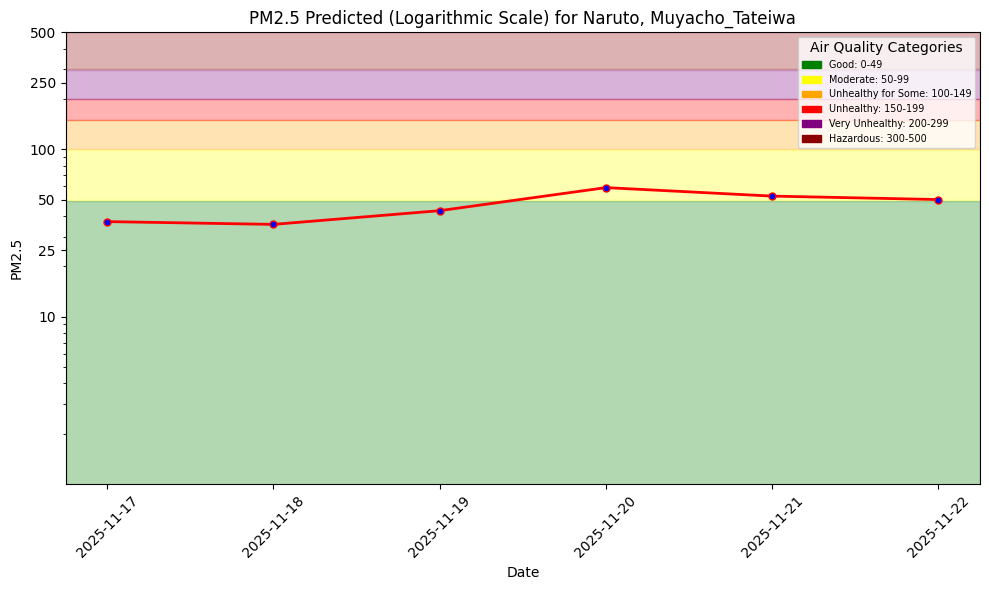

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1721732


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_naruto_muyacho_tateiwa_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_naruto_muyacho_tateiwa_1_offline_fg_materialization/executions
2025-11-16 15:25:57,247 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 15:26:00,421 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:27:43,023 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:27:43,192 INFO: Waiting for log aggregation to finish.
2025-11-16 15:27:51,826 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


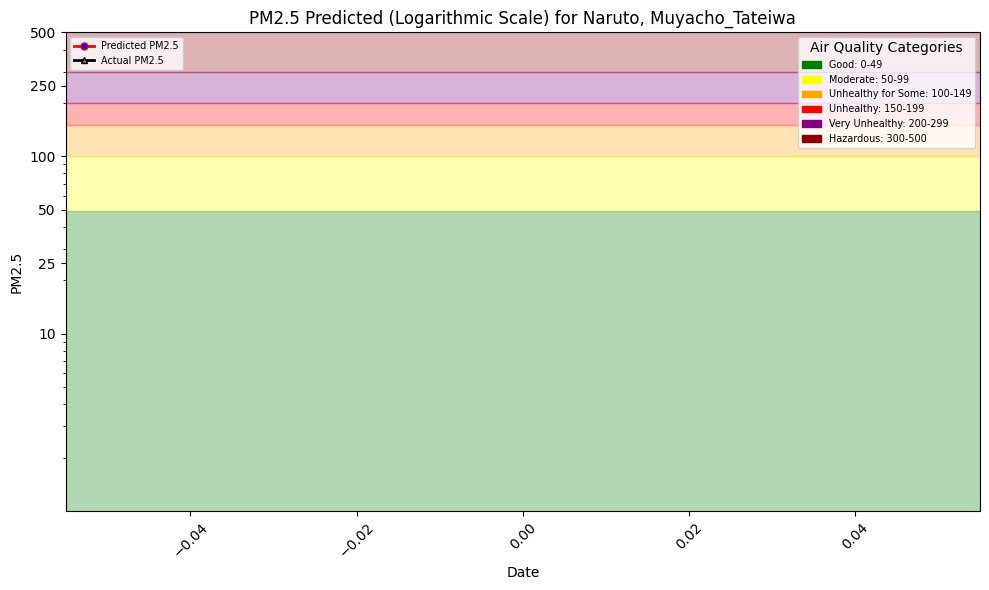

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_naruto_muyacho_tateiwa.png: 0.000%|…

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_naruto_muyacho_tateiwa.png: 0.…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:28:01,159 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:28:01,173 INFO: Initializing external client
2025-11-16 15:28:01,173 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:28:01,810 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:28:02,693 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_kitajima_tainohama', version: 1)
2025-11-16 15:28:07,671 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/553109 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112260 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26577 elapsed<00:00 remaining<?

XGBRegressor(base_score='4.2069725E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
Finished: Reading data from Hopsworks, using 

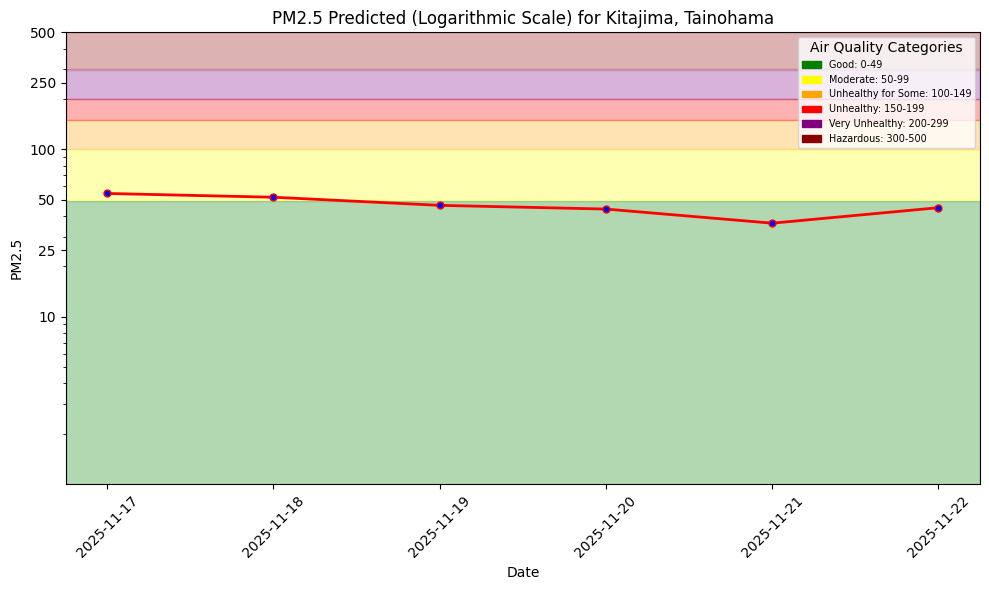

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1721735


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_kitajima_tainohama_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_kitajima_tainohama_1_offline_fg_materialization/executions
2025-11-16 15:28:36,982 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 15:28:40,184 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:30:12,495 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:30:12,658 INFO: Waiting for log aggregation to finish.
2025-11-16 15:30:21,406 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


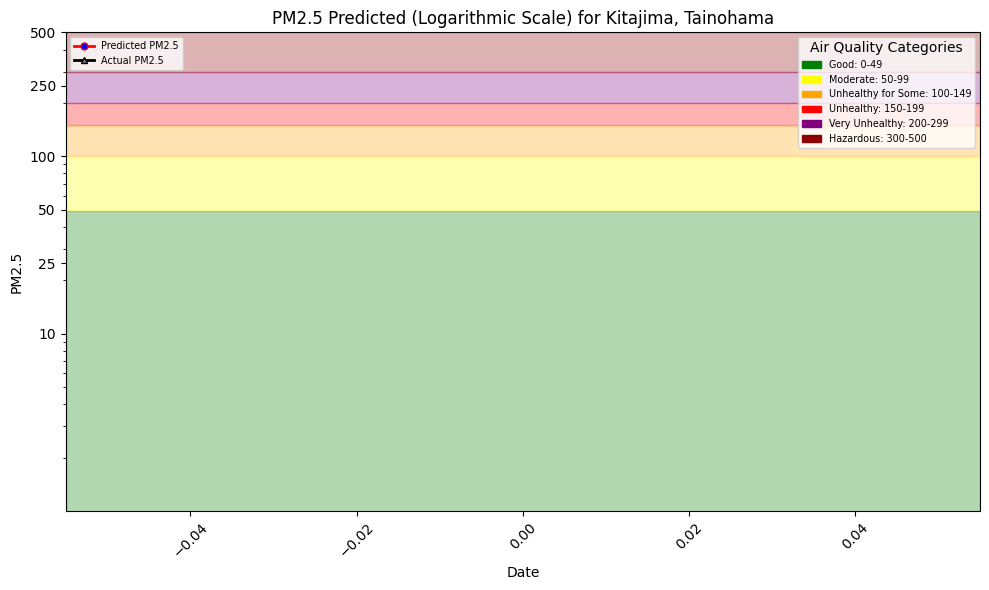

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_kitajima_tainohama.png: 0.000%|    …

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_kitajima_tainohama.png: 0.000%…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:30:30,792 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:30:30,808 INFO: Initializing external client
2025-11-16 15:30:30,809 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:30:31,419 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:30:32,239 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_tokushima_shinkuracho', version: 1)
2025-11-16 15:30:36,758 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/536150 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113809 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26554 elapsed<00:00 remaining<?

XGBRegressor(base_score='3.7607304E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 
Finished: Reading data from Hopsworks, using 

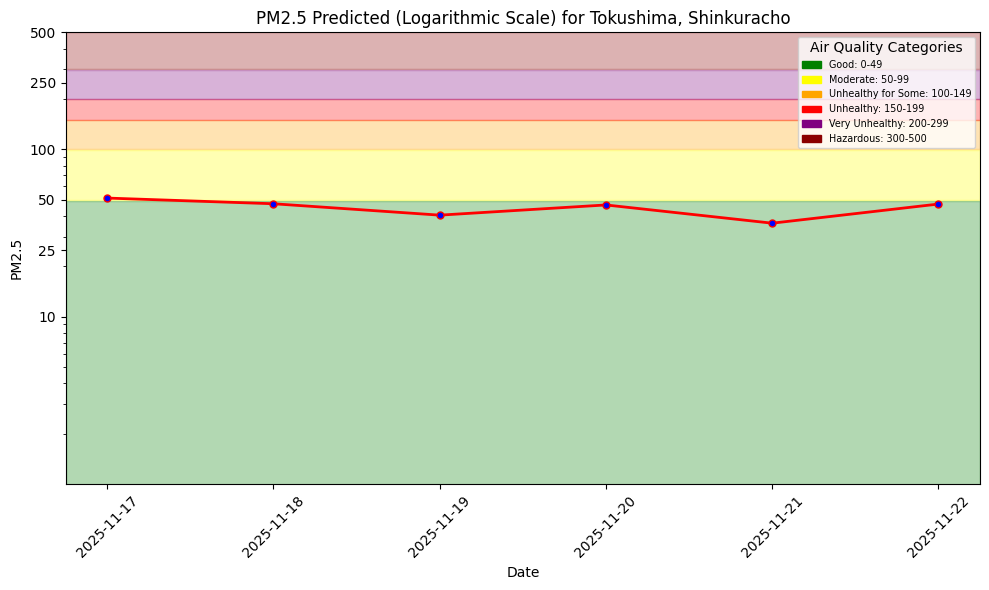

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1718720


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_tokushima_shinkuracho_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_tokushima_shinkuracho_1_offline_fg_materialization/executions
2025-11-16 15:31:05,308 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:31:08,481 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:32:52,099 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:32:52,296 INFO: Waiting for log aggregation to finish.
2025-11-16 15:33:00,922 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.16s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


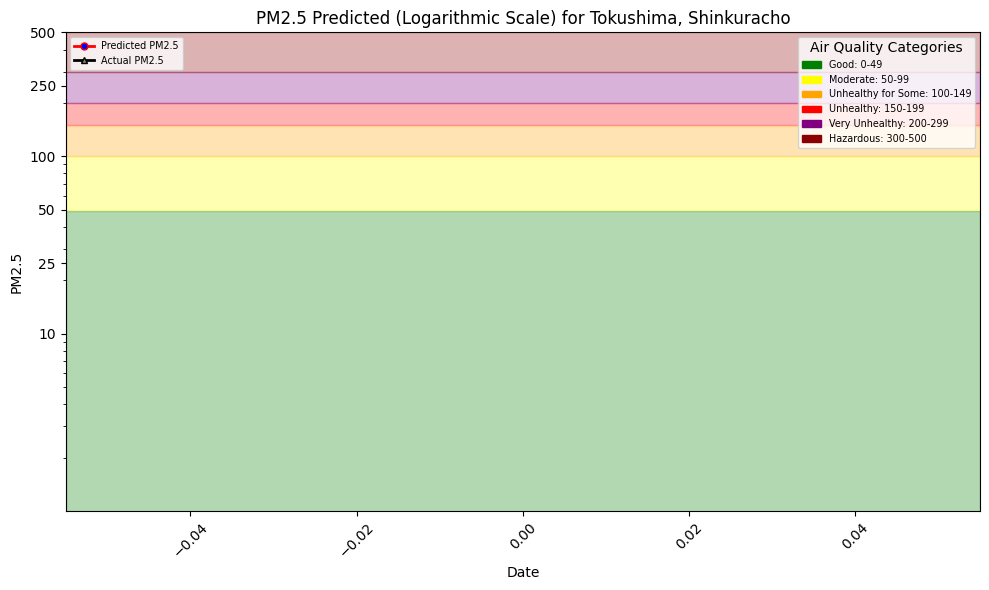

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_tokushima_shinkuracho.png: 0.000%| …

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_tokushima_shinkuracho.png: 0.0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:33:13,121 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:33:13,192 INFO: Initializing external client
2025-11-16 15:33:13,194 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:33:13,874 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:33:14,763 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_jinryo_main_street', version: 1)
2025-11-16 15:33:20,108 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/544907 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111019 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26668 elapsed<00:00 remaining<?

XGBRegressor(base_score='3.628915E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 
Finished: Reading data from Hopsworks, using H

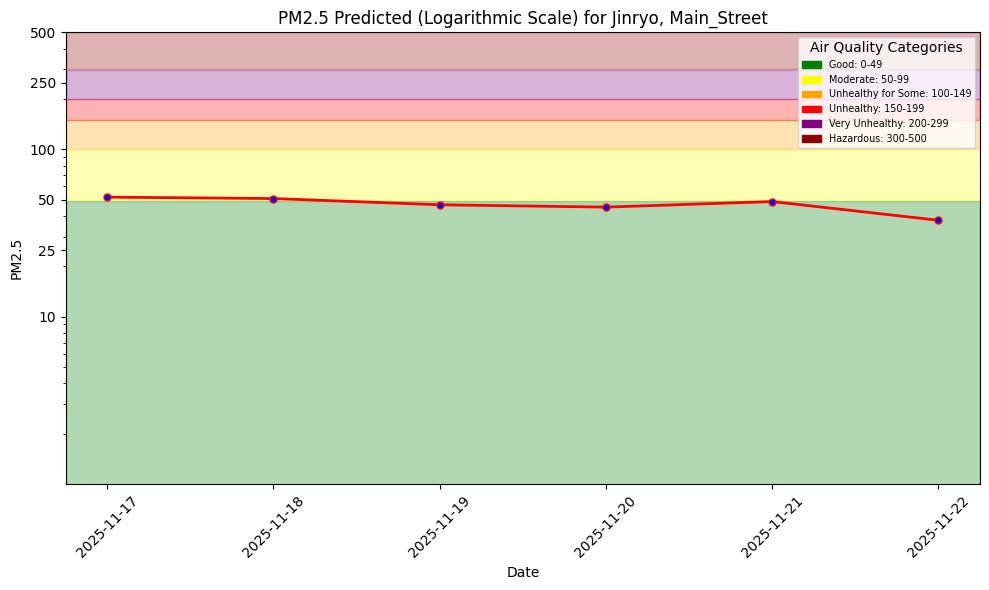

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1721737


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_jinryo_main_street_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_jinryo_main_street_1_offline_fg_materialization/executions
2025-11-16 15:33:57,557 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:34:00,737 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:35:26,606 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:35:26,772 INFO: Waiting for log aggregation to finish.
2025-11-16 15:35:42,120 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.37s) 


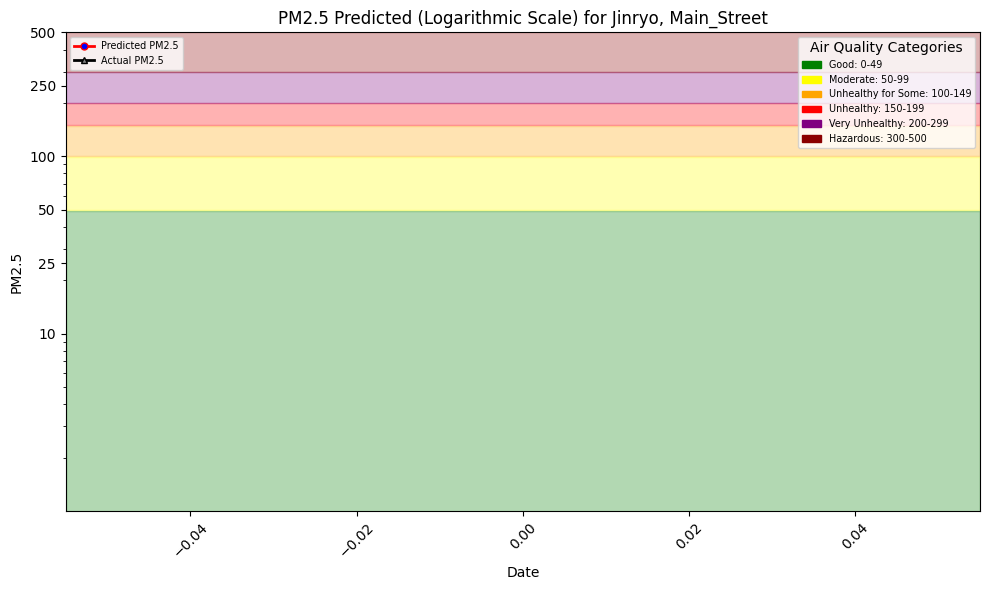

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_jinryo_main_street.png: 0.000%|    …

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_jinryo_main_street.png: 0.000%…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:35:51,595 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:35:51,602 INFO: Initializing external client
2025-11-16 15:35:51,603 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:35:52,256 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:35:53,148 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_anan_nakagawacho_kuroji', version: 1)
2025-11-16 15:35:57,886 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/554679 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/107648 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26523 elapsed<00:00 remaining<?

XGBRegressor(base_score='4.1318832E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.55s) 
Finished: Reading data from Hopsworks, using 

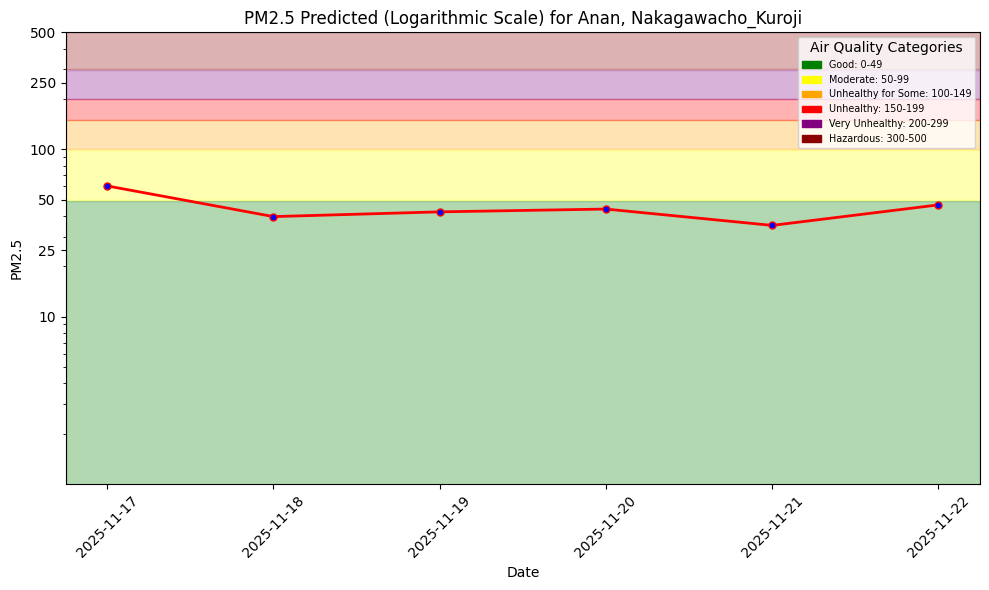

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1724769


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_anan_nakagawacho_kuroji_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_anan_nakagawacho_kuroji_1_offline_fg_materialization/executions
2025-11-16 15:36:26,293 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:36:32,614 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:38:23,992 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:38:24,158 INFO: Waiting for log aggregation to finish.
2025-11-16 15:38:36,162 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.34s) 


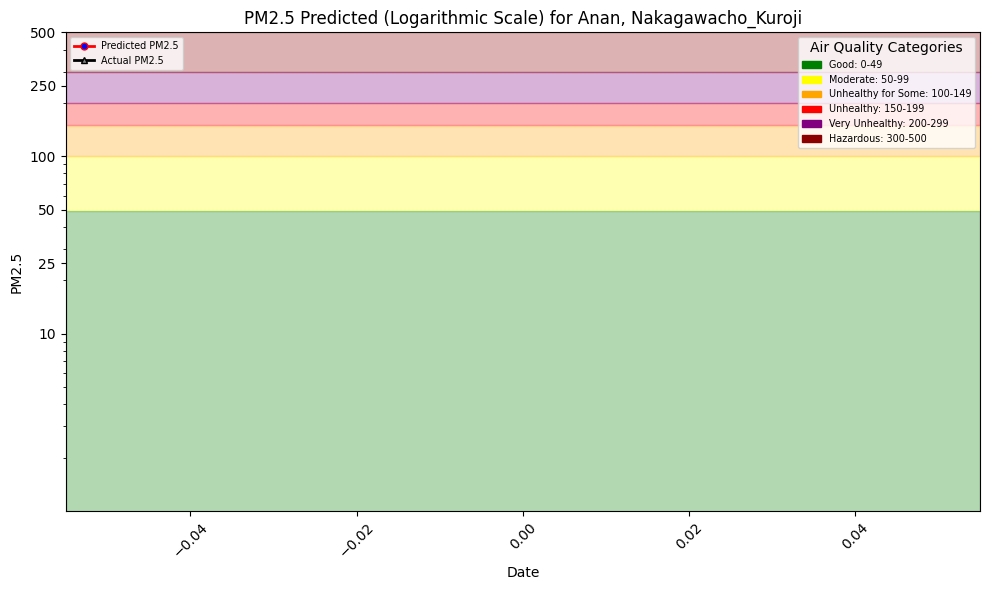

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_anan_nakagawacho_kuroji.png: 0.000%…

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_anan_nakagawacho_kuroji.png: 0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade
2025-11-16 15:38:46,215 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:38:46,225 INFO: Initializing external client
2025-11-16 15:38:46,226 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:38:46,876 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:38:47,728 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
Model(name: 'air_quality_xgboost_model_v_agrade_nishinoji_main_street', version: 1)
2025-11-16 15:38:52,778 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/544240 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/103067 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26816 elapsed<00:00 remaining<?

XGBRegressor(base_score='3.931513E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 
Finished: Reading data from Hopsworks, using H

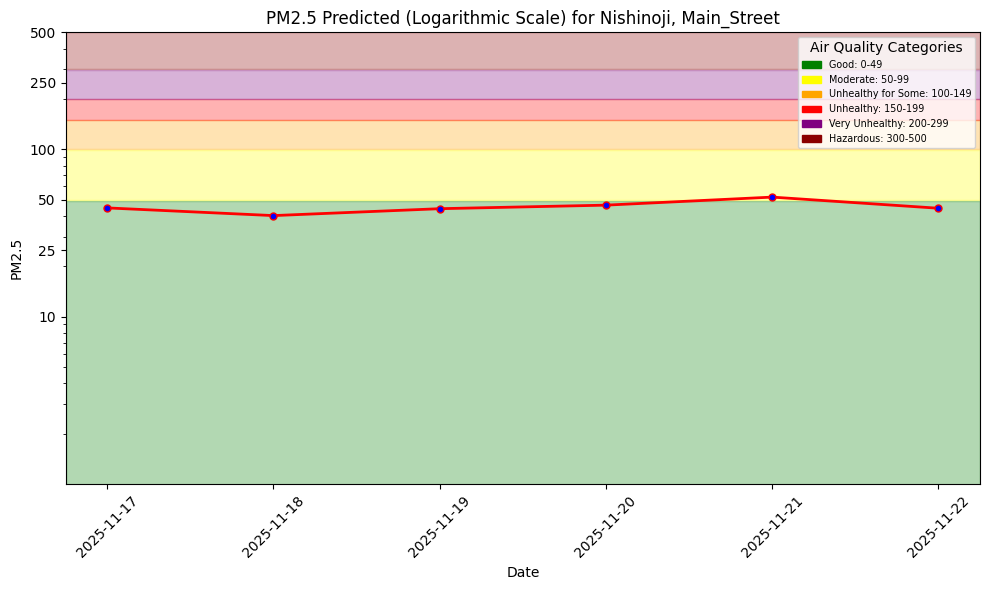

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fg/1721744


Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_nishinoji_main_street_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_agrade_nishinoji_main_street_1_offline_fg_materialization/executions
2025-11-16 15:39:20,872 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:39:24,063 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:41:15,241 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 15:41:15,655 INFO: Waiting for log aggregation to finish.
2025-11-16 15:41:15,657 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


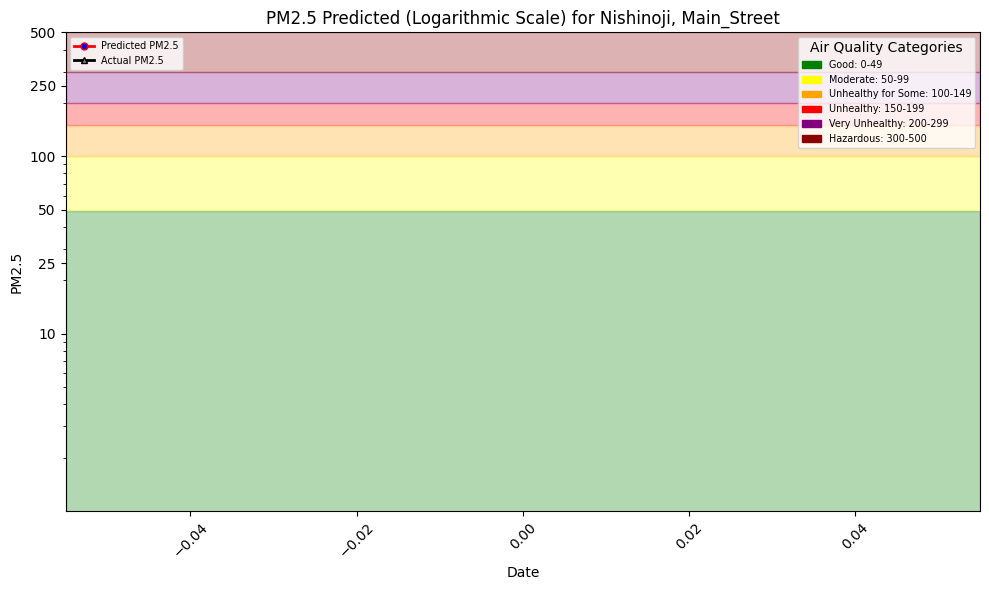

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast_nishinoji_main_street.png: 0.000%| …

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_nishinoji_main_street.png: 0.0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_agrade


In [81]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)

#locations = {"imahashi":"https://api.waqi.info/feed/@2543", "azuma":"https://api.waqi.info/feed/@2374", 
#             "oiwa":"https://api.waqi.info/feed/@2373", "noyori":"https://api.waqi.info/feed/@6600", "osaki":"https://api.waqi.info/feed/@2372"}
locations = {"https://api.waqi.info/feed/@4897":["Miyoshi", "Ikedacho_Machi"], "https://api.waqi.info/feed/@4896":["Mima","Wakimachi_Oaza_Inoshiri"], 
             "https://api.waqi.info/feed/@4877":["Naruto","Muyacho_Tateiwa"], "https://api.waqi.info/feed/@4881":["Kitajima","Tainohama"], 
             "https://api.waqi.info/feed/@4876":["Tokushima","Shinkuracho"], "https://api.waqi.info/feed/@4879":["Jinryo","Main_Street"], 
             "https://api.waqi.info/feed/@4895":["Anan","Nakagawacho_Kuroji"], "https://api.waqi.info/feed/@4898":["Nishinoji","Main_Street"]}

def full_pipeline(stations):

    for location in stations:
    
    
        url= location
        city= stations[location][0]
        country= "Japan"
        street= stations[location][1]
        

        project, fs, country, city, street = get_env(street,city)
    
        retrieved_xgboost_model,fv = get_model(project,street,city)    

        print(retrieved_xgboost_model)
    
        batch_data, weather_fg = get_forecast_stuff(fs,street,today,city)
    
        batch_data, adj_tomorrow, first_init_roll = add_rolling(fs,street,batch_data,city)
    
        batch_data = predictions(adj_tomorrow,batch_data,retrieved_xgboost_model,country,city,street,url,first_init_roll)
    
        batch_data = add_info_data(batch_data,street,city,country)
    
        pred_file_path = create_forecast(street,city,batch_data)
    
        monitor_fg = create_monitor_fg(street,batch_data,fs,city)
    
        monitoring_df = create_monitor_df(monitor_fg)
    
        air_quality_fg, air_quality_df = create_aq_df(fs,street,city)
    
        hindcast_df = hindcast(air_quality_df, monitoring_df)
    
        hindcast_file_path = plot_hindcast(street,city,hindcast_df)
    
        upload_hops(project, today, city, street,pred_file_path,hindcast_file_path)

full_pipeline(locations)

---